In [34]:
import geopandas as gpd
import rasterio as rio
from rasterio import features
from rasterio import Affine
from rasterio.plot import show
import rioxarray as riox
import xarray as xr
import glob
import os
import numpy as np
import re
import pandas as pd
from xrspatial import convolution, focal

In [2]:
def shp2mask(shp, xr_object, transform, outshape, fill=0, dtype='int16', **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=transform,
                                out_shape=outshape, dtype=dtype, **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

In [9]:
shps_f_list = glob.glob('./cnn_pred_results/burrow_pts_pred_*.shp')
cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [4]:
cper = gpd.read_file(cper_f)

<AxesSubplot:>

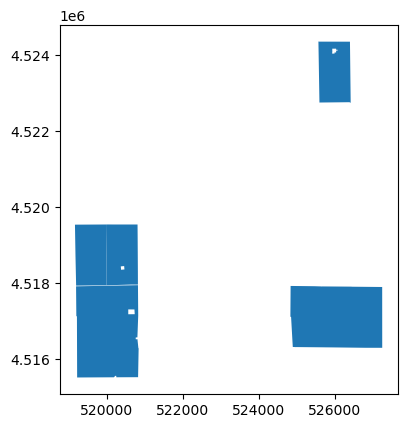

In [5]:
cper.plot()

In [6]:
cell_size = 5.0
transform = rio.transform.from_origin(cper.total_bounds[0],cper.total_bounds[3],cell_size, cell_size)
cper_ras = features.rasterize(zip(cper.geometry, cper.OBJECTID),
                   fill=0, 
                   transform=transform,
                   out_shape=(int(np.ceil((cper.total_bounds[3] - cper.total_bounds[1])/cell_size)),
                              int(np.ceil((cper.total_bounds[2] - cper.total_bounds[0])/cell_size))),
                   dtype=int)

In [7]:
cper_xr = xr.DataArray(cper_ras, 
             coords=(np.arange(cper.total_bounds[3], cper.total_bounds[1], -cell_size),
                    np.arange(cper.total_bounds[0], cper.total_bounds[2], cell_size)),
             dims=('y', 'x'))

In [8]:
cper_xr = cper_xr.where(cper_xr != 0)

In [64]:
pts_density_list = []

In [94]:
from tqdm import tqdm
for i in tqdm(np.unique(cper_xr.values)):
    if np.isnan(i):
        continue
    else:
        past_row = cper[cper['OBJECTID'] == i]
        shps_f_list_sub = [x for x in shps_f_list if past_row['Past_Name_'].iloc[0] in x]
        for f in shps_f_list_sub:
            pts_tmp = gpd.read_file(f)
            pts_tmp = pts_tmp[pts_tmp.geometry != None]
            pts_xr = shp2mask(pts_tmp.geometry, cper_xr, cper_xr.rio.transform(), cper_xr.shape,
                              default_value=1, merge_alg=features.MergeAlg.add)
            cellsize_x, cellsize_y = convolution.calc_cellsize(pts_xr)
            kernel = convolution.circle_kernel(cellsize_x, cellsize_y, radius=56.42)
            pts_density_tmp = focal.apply(pts_xr.where(cper_xr == i),
                                                kernel, 
                                                focal._calc_sum).where(cper_xr == i)
            pts_density_list.append(pts_density_tmp.where(pts_density_tmp != 0))

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:02<00:00, 10.37s/it]


In [95]:
pts_density_xr = xr.DataArray(np.nanmean(pts_density_list, axis=0), 
             coords=(cper_xr.y, cper_xr.x),
             dims=('y', 'x'))

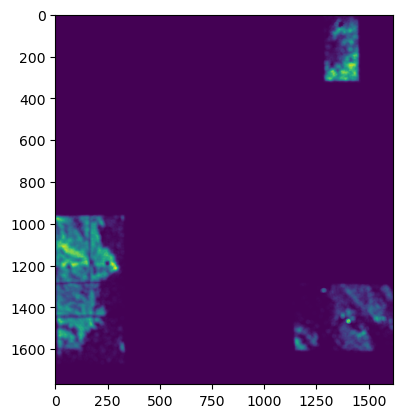

<AxesSubplot:>

In [96]:
show(pts_density_xr.data)

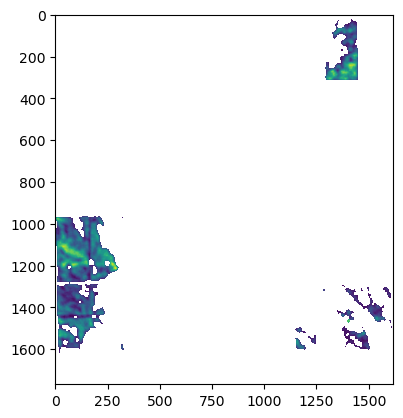

<AxesSubplot:>

In [105]:
show(pts_density_xr.where(pts_density_xr > 5).data)

In [107]:
da_active =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_active_yrs.tif').squeeze()
da_old =  riox.open_rasterio('./ground_data/PdogMapping_Sept2021/Sept2021_old_yrs.tif').squeeze()

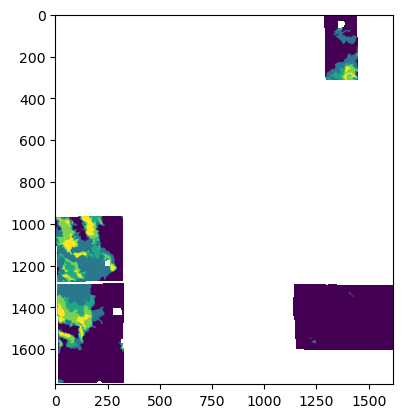

<AxesSubplot:>

In [108]:
show(da_active.data)

In [117]:
df_active = da_active.to_dataframe(name='yrs_active')
df_old = da_old.to_dataframe(name='yrs_old')
df_pts_density = pts_density_xr.to_dataframe(name='pts_density')

In [118]:
df_out = pd.merge(pd.merge(df_active, df_old, left_index=True, right_index=True),
                  df_pts_density, left_index=True, right_index=True)

In [119]:
df_out

band_x  spatial_ref_x  yrs_active  band_y  \
y            x                                                        
4.524365e+06 519167.8595       1              0         NaN       1   
             519172.8595       1              0         NaN       1   
             519177.8595       1              0         NaN       1   
             519182.8595       1              0         NaN       1   
             519187.8595       1              0         NaN       1   
...                          ...            ...         ...     ...   
4.515525e+06 527232.8595       1              0         NaN       1   
             527237.8595       1              0         NaN       1   
             527242.8595       1              0         NaN       1   
             527247.8595       1              0         NaN       1   
             527252.8595       1              0         NaN       1   

                          spatial_ref_y  yrs_old  pts_density  
y            x                                                 
4.524365e+06 519167.8595              0      NaN          0.0  
             519172.8595              0      NaN          0.0  
             519177.8595              0      NaN          0.0  
             519182.8595              0      NaN          0.0  
             519187.8595              0      NaN          0.0  
...                                 ...      ...          ...  
4.515525e+06 527232.8595              0      NaN          0.0  
             527237.8595              0      NaN          0.0  
             527242.8595              0      NaN          0.0  
             527247.8595              0      NaN          0.0  
             527252.8595              0      NaN          0.0  

[2862242 rows x 7 columns]

<AxesSubplot:xlabel='yrs_active', ylabel='pts_density'>

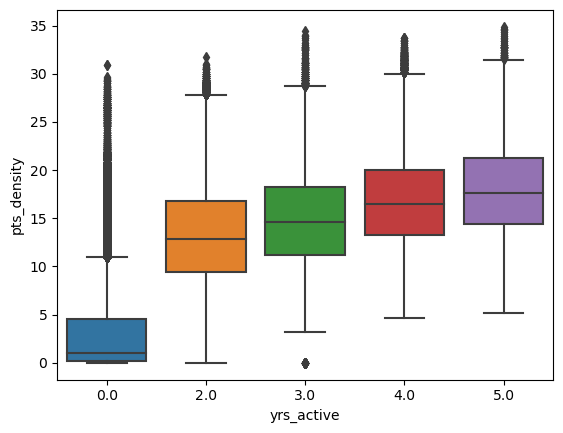

In [121]:
import seaborn as sns
sns.boxplot(x='yrs_active', y='pts_density', data=df_out)